In [1]:
import os
import pickle
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

import arviz as az
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import MixtureModel
from constants import (
    DATA_PATH,
    TOML_PATH,
    INFERENCE_FILE,
    NETCODE_FILE,
    BUILD_DIR
)

plt.rcParams["svg.fonttype"] = "none"
logger = logging.getLogger(__name__)

logger = logging.getLogger(__name__)
setup_logging(dir=BUILD_DIR, fname="figure")
plt.rcParams["svg.fonttype"] = "none"


2024-03-12 13:24:02,674 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/tms/group-comparison/figure.log


In [2]:
M = MixtureModel

# Load posterior
dest = os.path.join(BUILD_DIR, M.NAME, INFERENCE_FILE)
with open(dest, "rb") as f:
    model, mcmc, posterior_samples_ = pickle.load(f)

posterior_samples = posterior_samples_.copy()
posterior_samples[site.outlier_prob] = 0 * posterior_samples[site.outlier_prob]

# Load data
df = pd.read_csv(DATA_PATH)
df, encoder_dict = model.load(df=df)

subset = [(5, 1), (18, 0)]
ind = df[model.features].apply(tuple, axis=1).isin(subset)
df = df[ind].reset_index(drop=True).copy()


2024-03-12 13:24:02,690 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2024-03-12 13:24:02,691 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-03-12 13:24:02,691 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-03-12 13:24:03,608 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/tms/group-comparison/mixture_model
2024-03-12 13:24:03,610 - hbmep.dataset.core - INFO - Processing data ...
2024-03-12 13:24:03,611 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
a_loc = posterior_samples["a_loc"]
a_loc.shape

(4000, 2, 3)

In [4]:
encoder_dict[model.features[1]].inverse_transform([0, 1])


array(['SCI', 'Uninjured'], dtype=object)

In [5]:
((a_loc[:, 0, :] - a_loc[:, 1, :]) > 0).mean(axis=0)


array([0.9035 , 0.90425, 0.97325])

In [6]:
response_colors = {
    0: (0.8157, 0.1098, 0.5451),
    1: (0.2055, 0., 0.4000),
    2: (0.3000, 0.3000, 0.3000)
}
prior_color = (.7, .7, .7)


In [7]:
prediction_df = model.make_prediction_dataset(df=df, num_points=5000)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)


2024-03-12 13:24:03,816 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2024-03-12 13:24:50,206 - hbmep.utils.utils - INFO - func:predict took: 46.39 sec


In [8]:
a = posterior_samples[site.a]
a_map = a.mean(axis=0)

mu = posterior_predictive[site.mu]

obs = posterior_predictive[site.obs]
obs_hpdi = hpdi(obs, prob=.95)


In [9]:
import numpyro.distributions as dist


2024-03-12 13:28:24,793 - __main__ - INFO - Saved figure to /home/vishu/repos/hbmep-paper/reports/tms/group-comparison/sci-uninjured.png


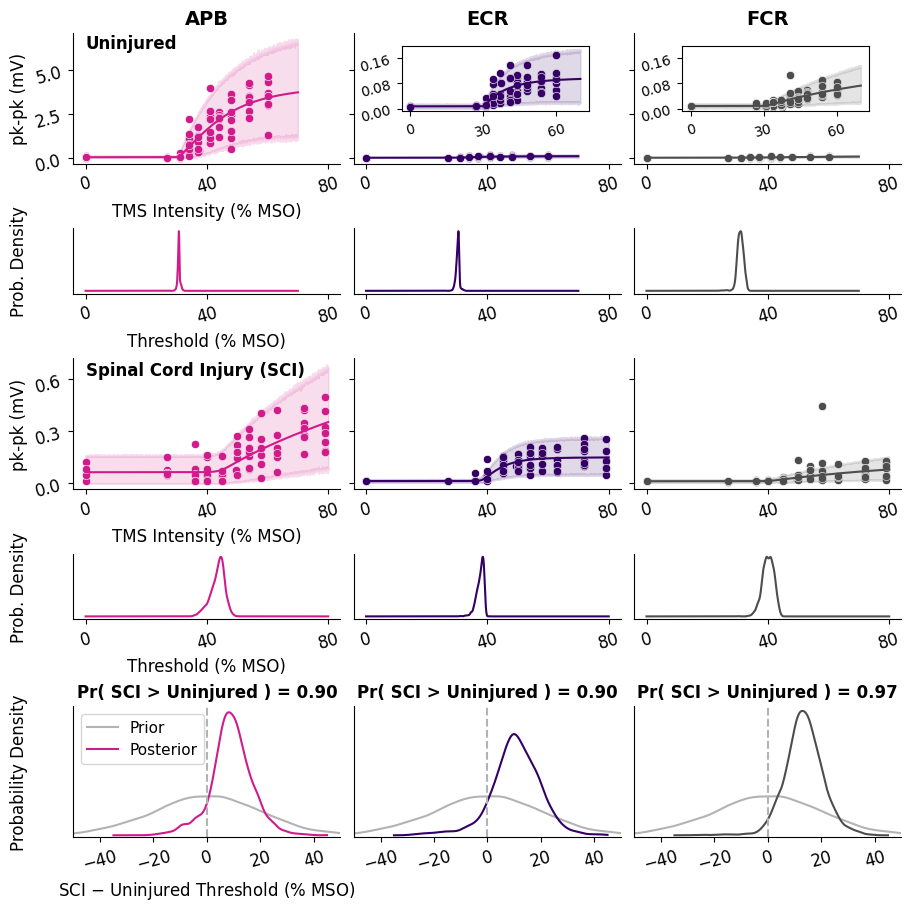

In [14]:
response = ["APB", "ECR", "FCR"]
axis_label_size = 12

""" Plot """
nrows, ncols = 5, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 1.8 * nrows), squeeze=False, height_ratios=[1, .5, 1, .5, 1], constrained_layout=True)

rec_ins = []

for muscle_ind in range(model.n_response):
    color = response_colors[muscle_ind]

    for c_counter, c in enumerate([(5, 1), (18, 0)]):
        ind = df[model.features].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, muscle_ind]
        temp_mu = mu[:, pred_ind, muscle_ind]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

        ax = axes[2 * c_counter, muscle_ind]
        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ax, color=color)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ax)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=color,
            alpha=.15
        )
        ax.sharex(axes[0, 0])
        ax.sharey(axes[2 * c_counter, 0])

        if (c, muscle_ind) in [((5, 1), 1), ((5, 1), 2)]:
            ins = ax.inset_axes([0.18,0.4,0.7 ,0.5])
            rec_ins.append(ins)
            sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ins, color=color)
            sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ins)
            ins.fill_between(
                temp_pred_df[model.intensity],
                temp_obs_hpdi[0, :],
                temp_obs_hpdi[1, :],
                color=color,
                alpha=.15
            )
            ins.set_xlabel("")
            ins.set_ylabel("")
            ins.xaxis.set_major_locator(plt.MaxNLocator(3))
            ins.yaxis.set_major_locator(plt.MaxNLocator(3))
            # ins.set_xlim(left=4, right=6)
            ins.tick_params(
                axis='both',
                which='both',
                left=True,
                bottom=True,
                right=False,
                top=False,
                labelleft=True,
                labelbottom=True,
                labelright=False,
                labeltop=False,
                labelrotation=15,
                labelsize=10
            )

        ax = axes[2 * c_counter + 1, muscle_ind]
        samples = a[:, *c, muscle_ind]
        # sns.kdeplot(a[:, *c, muscle_ind], ax=ax, color=color)
        kde = stats.gaussian_kde(samples)
        x_grid = temp_pred_df[model.intensity].unique()
        density = kde(x_grid)
        ax.plot(x_grid, density, color=color)
        ax.sharex(axes[0, 0])

    ax = axes[4, muscle_ind]
    d = dist.Normal(0, 20)
    prior = d.sample(model.rng_key, (10000, ))
    sns.kdeplot(prior, ax=ax, color=prior_color, label="Prior")
    samples = a_loc[:, 0, muscle_ind] - a_loc[:, 1, muscle_ind]
    # sns.kdeplot(samples, ax=ax, color=color, label="Posterior")
    x_grid = np.linspace(-35, 45, 5000)
    kde = stats.gaussian_kde(samples)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=color, label="Posterior")
    ax.set_xlim(-50, 50)
    ax.set_ylim(bottom=-.001)

    # kde = stats.gaussian_kde(samples)
    # # x_grid = prediction_df[model.intensity].unique()
    # x_grid = np.arange(-20, 40, .05)
    # density = kde(x_grid)
    # ax.plot(x_grid, density, color=color, label="Posterior")

    prob = (samples > 0).mean()
    ax.set_title(f"Pr( SCI > Uninjured ) = {prob:.2f}", fontweight="bold", size=12)
    ax.sharex(axes[4, 0])
    ax.sharey(axes[4, 0])
    ax.axvline(x=0, color=prior_color, linestyle="--")

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15,
            labelsize=12
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

for muscle_ind in range(model.n_response):
    for c_counter, c in enumerate([(5, 1), (18, 0)]):
        ax = axes[2 * c_counter, muscle_ind]
        if muscle_ind == 0:
            ax.set_xlabel("TMS Intensity (% MSO)", size=axis_label_size)

        ax = axes[2 * c_counter + 1, muscle_ind]
        if muscle_ind == 0:
            ax.set_xlabel("Threshold (% MSO)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

    ax = axes[4, muscle_ind]
    if muscle_ind == 0:
        ax.set_xlabel("SCI $-$ Uninjured Threshold (% MSO)", size=axis_label_size)
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
        labelrotation=15
    )
    ax = axes[0, muscle_ind]
    ax.set_title(response[muscle_ind], fontweight="bold", fontsize=14)
    # ax.set_title(response[muscle_ind], fontweight="bold", color=response_colors[muscle_ind])

ax = axes[0, 0]
ax.tick_params(
    axis='both',
    which='both',
    labelleft=True,
    labelrotation=15
)
ax.set_ylabel("pk-pk (mV)", size=axis_label_size)
ax.set_xticks([0, 40, 80])
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.text(.001, 6.5, "Uninjured", size=12, ha="left", va="center", fontweight="bold")

ax = axes[1, 0]
ax.set_ylabel("Prob. Density", size=axis_label_size)

ax = axes[2, 0]
ax.set_ylabel("pk-pk (mV)", size=axis_label_size)
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    labelleft=True,
)
ax.text(.001, 0.65, "Spinal Cord Injury (SCI)", size=12, ha="left", va="center", fontweight="bold")

ax = axes[3, 0]
ax.set_ylabel("Prob. Density", size=axis_label_size)

ax = axes[4, 0]
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    labelleft=False,
    labelbottom=True,
    labelrotation=15
)
ax.set_ylabel("Probability Density", size=axis_label_size)
ax.set_xticks([-40, -20, 0, 20, 40])
ax.legend(loc="upper left", fontsize=11)

rec_ins[1].sharex(rec_ins[0])
rec_ins[1].sharey(rec_ins[0])

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(BUILD_DIR, "sci-uninjured.svg")
fig.savefig(dest, dpi=600)
dest = os.path.join(BUILD_DIR, "sci-uninjured.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved figure to {dest}")
